# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

This time we use the **PPO** (Proximal Policy Optimization) algorithm!

In [ ]:
#restart the kernel once after install this package
#!pip install 'gym<0.25.0'
#!pip install 'gym[atari, accept-rom-license]'

In [1]:
# Watch for changes
%load_ext autoreload
%autoreload 2

# custom utilies for displaying animation, collecting rollouts and more
import numpy as np
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

# Monkey patch missing attributes for newer numpy versions
if not hasattr(np, "float_"):
    np.float_ = np.float64
    
if not hasattr(np, "int_"):
    np.int_ = np.int64

if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

using device:  cuda:0


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



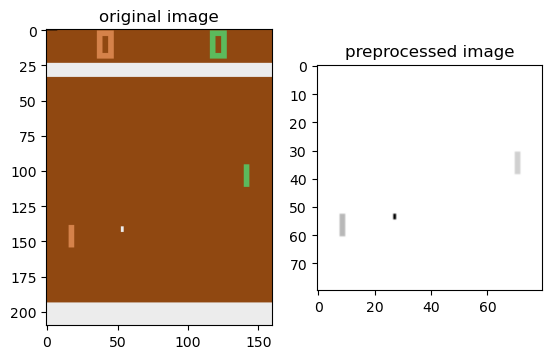

In [3]:
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _,_ , _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()


# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving right. Note that $P_{\rm left}= 1-P_{\rm right}$

This here was a given policy. We try our own policy below.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SolutionPolicy(nn.Module):

    def __init__(self):
        super(SolutionPolicy, self).__init__()
        
        # 80x80x2 to 38x38x4
        # 2 channel from the stacked frame
        self.conv1 = nn.Conv2d(2, 4, kernel_size=6, stride=2, bias=False)
        # 38x38x4 to 9x9x32
        self.conv2 = nn.Conv2d(4, 16, kernel_size=6, stride=4)
        self.size=9*9*16
        
        # two fully connected layer
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)

        # Sigmoid to 
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        # Assume the preprocessed Pong input is an 80x80 image with 2 channels (e.g., frame difference or stacked frames)
        # Conv layer 1: 2 input channels → 16 filters; kernel size=8, stride=4.
        # Output size: ((80-8)//4 + 1) = 19, so output: 16 x 19 x 19.
        self.conv1 = nn.Conv2d(2, 16, kernel_size=8, stride=4)
        
        # Conv layer 2: 16 → 32 filters; kernel size=4, stride=2.
        # Output size: ((19-4)//2 + 1) = 8, so output: 32 x 8 x 8.
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        
        # Conv layer 3: 32 → 64 filters; kernel size=3, stride=1.
        # Output size: ((8-3)//1 + 1) = 6, so output: 64 x 6 x 6.
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        
        # Flattened size = 64 * 6 * 6 = 2304.
        self.fc1 = nn.Linear(64 * 6 * 6, 256)
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Pass input through conv layers with ReLU activations.
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        # Flatten the tensor for the fully connected layers.
        x = x.view(x.size(0), -1)
        
        # Pass through a fully connected layer.
        x = F.relu(self.fc1(x))

        # Output a single probability (for moving right).
        return self.sigmoid(self.fc2(x))        

policy=Policy().to(device)

# we use the adam optimizer with learning rate 1e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress

In [18]:
pong_utils.play(env, policy, time=100, preprocess=pong_utils.preprocess_single) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Rollout
Before we start the training, we need to collect samples. To make things efficient we use parallelized environments to collect multiple examples at once

In [5]:
envs = pong_utils.parallelEnv('PongDeterministic-v4', n=4, seed=1234)
prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=100)

In [8]:
print(prob)

[array([0.49985403, 0.5001674 , 0.50015616, 0.5001454 ], dtype=float32), array([0.4998473 , 0.4998414 , 0.50013745, 0.5001454 ], dtype=float32), array([0.4998014 , 0.5002025 , 0.50021076, 0.5001867 ], dtype=float32), array([0.5001572, 0.4998511, 0.4998501, 0.4998572], dtype=float32), array([0.49977624, 0.4997812 , 0.4997812 , 0.49979442], dtype=float32), array([0.49984032, 0.5001687 , 0.5001687 , 0.49983692], dtype=float32), array([0.5001698 , 0.49980593, 0.49980593, 0.5001674 ], dtype=float32), array([0.4998381 , 0.49981207, 0.50018793, 0.50019276], dtype=float32), array([0.4998678 , 0.49986023, 0.49983197, 0.5001511 ], dtype=float32), array([0.50013775, 0.49986225, 0.50014776, 0.500138  ], dtype=float32), array([0.50013345, 0.5001314 , 0.500143  , 0.49987847], dtype=float32), array([0.49986303, 0.4998241 , 0.49984264, 0.49985415], dtype=float32), array([0.50014   , 0.5001624 , 0.50016004, 0.5001598 ], dtype=float32), array([0.5000043 , 0.49994648, 0.50003093, 0.5000238 ], dtype=float

In [ ]:
# List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
print(action)

[array([5, 5, 5, 5]), array([5, 5, 4, 5]), array([4, 5, 4, 4]), array([4, 4, 4, 5]), array([4, 4, 5, 4]), array([4, 5, 4, 5]), array([5, 4, 4, 4]), array([4, 4, 4, 4]), array([4, 4, 4, 5]), array([4, 4, 4, 4]), array([5, 5, 5, 4]), array([4, 4, 5, 5]), array([4, 5, 4, 5]), array([5, 5, 4, 4]), array([5, 5, 4, 5]), array([5, 5, 5, 4]), array([4, 4, 5, 5]), array([5, 4, 4, 5]), array([5, 4, 4, 4]), array([4, 4, 5, 5]), array([5, 4, 5, 5]), array([5, 5, 5, 4]), array([4, 4, 4, 4]), array([4, 4, 4, 5]), array([5, 4, 4, 5]), array([5, 5, 5, 5]), array([4, 4, 5, 4]), array([5, 4, 5, 4]), array([4, 4, 5, 5]), array([4, 5, 4, 4]), array([5, 5, 4, 4]), array([4, 4, 4, 4]), array([4, 5, 4, 5]), array([4, 5, 4, 4]), array([5, 5, 4, 5]), array([4, 4, 5, 5]), array([5, 5, 4, 5]), array([4, 5, 5, 4]), array([5, 4, 4, 5]), array([5, 4, 4, 4]), array([4, 4, 5, 5]), array([4, 5, 4, 5]), array([5, 5, 4, 5]), array([5, 4, 4, 5]), array([4, 4, 4, 4]), array([4, 4, 4, 4]), array([4, 5, 4, 5]), array([5, 4,

In [11]:
print(state)

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
       

Let's visualise some trajectory data:

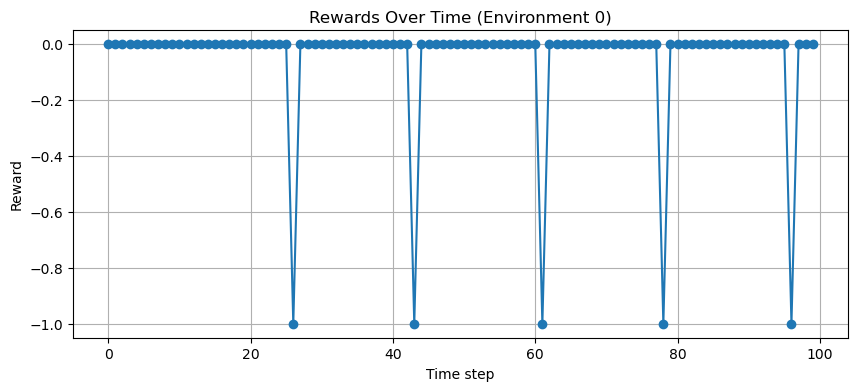

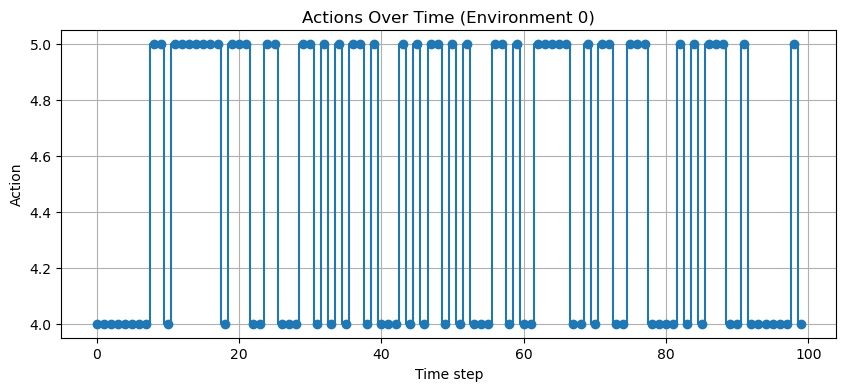

In [16]:
import matplotlib.pyplot as plt

# Assuming you have collected trajectories:
# prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=100)

# Extract data for environment 0 from each time step.
env_index = 0
rewards_env0 = [r[env_index] for r in reward]  # reward is a list of arrays (each of shape (4,))
actions_env0 = [a[env_index] for a in action]    # actions is a list of arrays (each of shape (4,))

# Plot rewards over time
plt.figure(figsize=(10, 4))
plt.plot(rewards_env0, marker='o')
plt.xlabel('Time step')
plt.ylabel('Reward')
plt.title('Rewards Over Time (Environment 0)')
plt.grid(True)
plt.show()

# Plot actions over time
plt.figure(figsize=(10, 4))
plt.step(range(len(actions_env0)), actions_env0, where='mid', marker='o')
plt.xlabel('Time step')
plt.ylabel('Action')
plt.title('Actions Over Time (Environment 0)')
plt.grid(True)
plt.show()

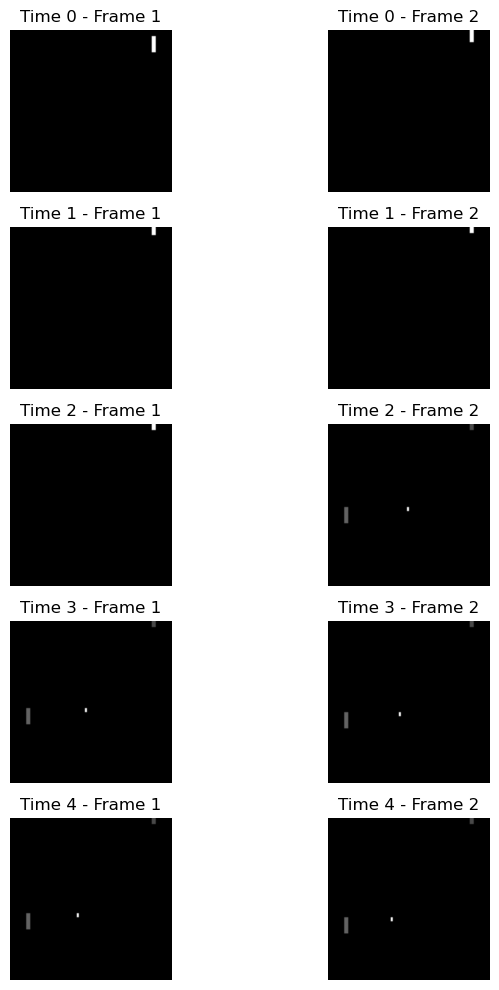

In [19]:
import matplotlib.pyplot as plt

def visualize_states_timesteps(state_list, env_index=0, n_timesteps=5):
    """
    Visualize state data for a parameterizable number of timesteps for a single environment.
    
    Parameters:
      state_list : list
          List of state batches from pong_utils.collect_trajectories. Each element is a batch
          with shape (n_env, 2, 80, 80) where n_env is the number of parallel environments.
      env_index : int, optional
          The index of the environment to visualize (default is 0).
      n_timesteps : int, optional
          Number of timesteps to visualize (default is 5).
    """
    # Limit the number of timesteps to the available length.
    n = min(n_timesteps, len(state_list))
    
    # Create a figure with n rows and 2 columns (for two frames per state)
    fig, axes = plt.subplots(n, 2, figsize=(8, 2*n))
    
    # If only one row is visualized, axes might not be a 2D array, so we ensure it is.
    if n == 1:
        axes = [axes]
    
    for i in range(n):
        # Each state_list[i] is a batch of shape (n_env, 2, 80, 80).
        # Extract the state for the selected environment.
        state_i = state_list[i][env_index]  # shape (2, 80, 80)
        
        # Extract frame 1 and frame 2.
        frame1 = state_i[0]
        frame2 = state_i[1]
        
        # If these frames are PyTorch tensors, convert them to numpy arrays.
        if hasattr(frame1, 'cpu'):
            frame1 = frame1.cpu().numpy()
        if hasattr(frame2, 'cpu'):
            frame2 = frame2.cpu().numpy()
        
        # Plot the two frames side by side.
        axes[i][0].imshow(frame1, cmap='gray')
        axes[i][0].axis('off')
        axes[i][0].set_title(f"Time {i} - Frame 1")
        
        axes[i][1].imshow(frame2, cmap='gray')
        axes[i][1].axis('off')
        axes[i][1].set_title(f"Time {i} - Frame 2")
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have already called:
# prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=100)
# Visualize states from environment 0 for 5 timesteps:
visualize_states_timesteps(state, env_index=0, n_timesteps=5)

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

Ok, let us use this in our surrogate function, which approximates the reward estimation so that we have a signal for the gradient ascent step.

In [8]:
def surrogate_ppo(policy, old_probs, states, actions, rewards,
                  discount=0.995, beta=0.01, epsilon=0.2):
    """
    Compute the PPO surrogate loss and return intermediate metrics.
    
    Parameters:
      policy: the current policy (neural network)
      old_probs: list or array of probabilities for the taken actions under the old policy
      states: list/array of states encountered in the trajectory
      actions: list/array of actions taken
      rewards: list/array of rewards received
      discount: discount factor for future rewards (default: 0.995)
      beta: entropy bonus coefficient (default: 0.01)
      epsilon: clipping parameter for importance sampling (default: 0.2)
    
    Returns:
      total_loss: the PPO surrogate loss (to be minimized)
      metrics: a dictionary containing intermediate metrics for logging
    """
    # Optimize conversion: convert list of numpy arrays to a single numpy array before tensor conversion.
    old_probs = torch.tensor(np.array(old_probs), dtype=torch.float32, device=device)
    
    # Convert actions to a tensor (ensure appropriate type and device)
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    
    # Compute new policy probabilities from states.
    new_probs = pong_utils.states_to_prob(policy, states)

    # Choose the probability corresponding to the taken action:
    # If the action equals pong_utils.RIGHT, use new_probs; otherwise, use 1-new_probs.
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0 - new_probs)
    
    # Compute the importance sampling ratio:
    # This is the ratio between the new probability and the old probability of the taken action.
    ratio = new_probs / (old_probs + 1e-10)
    
    # Compute discounted cumulative rewards (returns)
    discounted_rewards = []
    R = 0
    for r in reversed(rewards):
        R = r + discount * R
        discounted_rewards.insert(0, R)
        
    discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32, device=device)
    
    # Normalize discounted rewards to reduce variance.
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-10)

    # PPO surrogate objective: use clipping to prevent excessive policy updates.
    surrogate_term = torch.min(
        ratio * discounted_rewards,
        torch.clamp(ratio, 1.0 - epsilon, 1.0 + epsilon) * discounted_rewards
    )
    
    # The policy loss is the negative mean of the surrogate term.
    policy_loss = -torch.mean(surrogate_term)
    
    # Compute the entropy of the new policy (for a Bernoulli distribution)
    entropy = -(
        new_probs * torch.log(new_probs + 1e-10) +
        (1.0 - new_probs) * torch.log(1.0 - new_probs + 1e-10)
    )
    entropy_reg = beta * torch.mean(entropy)
    
    # Total loss: subtract the entropy bonus (since higher entropy is desirable)
    total_loss = policy_loss - entropy_reg

    # Collect metrics for logging
    metrics = {
        "ratio_mean": ratio.mean().item(),
        "ratio_min": ratio.min().item(),
        "ratio_max": ratio.max().item(),
        "normalized_reward_mean": discounted_rewards.mean().item(),
        "normalized_reward_std": discounted_rewards.std().item(),
        "policy_loss": policy_loss.item(),
        "entropy_reg": entropy_reg.item(),
        "total_loss": total_loss.item()
    }
    
    return total_loss, metrics

# Example usage:
Lsur, _ = surrogate_ppo(policy, prob, state, action, reward)

# Check loss value
print("Surrogate loss:", Lsur.item())

# Check gradients by doing a backward pass and printing gradient norms
optimizer.zero_grad()
Lsur.backward()

# Print norm of gradients for each parameter (or a summary statistic)
for name, param in policy.named_parameters():
    if param.grad is not None:
        print(f"Gradient norm for {name}: {param.grad.norm().item()}")
    else:
        print(f"No gradient for {name}")



Surrogate loss: -0.00693111727014184
Gradient norm for conv1.weight: 0.00011991828796453774
Gradient norm for conv1.bias: 0.0004175162175670266
Gradient norm for conv2.weight: 0.0008799347560852766
Gradient norm for conv2.bias: 0.001951172249391675
Gradient norm for conv3.weight: 0.0023066780995577574
Gradient norm for conv3.bias: 0.004523012787103653
Gradient norm for fc1.weight: 0.018369115889072418
Gradient norm for fc1.bias: 0.011082514189183712
Gradient norm for fc2.weight: 0.006338654085993767
Gradient norm for fc2.bias: 0.025973450392484665


Looks reasonable to me. Loss is not zero and gradients aren't zero either.

# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [9]:
import numpy as np
import progressbar as pb
import datetime
from torch.utils.tensorboard import SummaryWriter
from parallelEnv import parallelEnv

# Training loop parameters
episode = 500

# Initialize progress bar
widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

# Initialize TensorBoard SummaryWriter with current datetime
log_dir = "logs/ppo_training_" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter(log_dir=log_dir)

# Create parallel environments
envs = parallelEnv('PongDeterministic-v4', n=8)  # optionally add a seed here

# Hyperparameters
discount_rate = 0.99
epsilon = 0.1
beta = 0.01
tmax = 320
SGD_epoch = 4

# To track progress
mean_rewards = []

for e in range(episode):

    # Collect trajectories from the parallel environments.
    old_probs, states, actions, rewards = pong_utils.collect_trajectories(envs, policy, tmax=tmax)
    total_rewards = np.sum(rewards, axis=0)

    # Perform multiple gradient updates on the same batch of trajectories.
    for _ in range(SGD_epoch):
        loss, metrics = surrogate_ppo(policy, old_probs, states, actions, rewards,
                                      discount=discount_rate, beta=beta, epsilon=epsilon)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Decay hyperparameters over time.
    epsilon *= 0.999
    beta *= 0.995
    
    # Compute mean reward across all parallel environments.
    mean_reward = np.mean(total_rewards)
    mean_rewards.append(mean_reward)
    
    # Log metrics to TensorBoard
    writer.add_scalar("Reward/Mean", mean_reward, e)
    writer.add_scalar("Loss/Total", metrics["total_loss"], e)
    writer.add_scalar("Loss/Policy", metrics["policy_loss"], e)
    writer.add_scalar("Loss/Entropy", metrics["entropy_reg"], e)
    writer.add_scalar("Importance/Ratio_Mean", metrics["ratio_mean"], e)
    writer.add_scalar("Importance/Ratio_Min", metrics["ratio_min"], e)
    writer.add_scalar("Importance/Ratio_Max", metrics["ratio_max"], e)
    writer.add_scalar("NormalizedRewards/Mean", metrics["normalized_reward_mean"], e)
    writer.add_scalar("NormalizedRewards/Std", metrics["normalized_reward_std"], e)
    
    # Print progress every 20 episodes.
    if (e+1) % 20 == 0:
        print("Episode: {0:d}, score: {1:f}".format(e+1, mean_reward))
        print(total_rewards)
    
    # Update progress bar.
    timer.update(e+1)
    
timer.finish()
writer.close()

Episode: 20, score: -15.375000
[-15. -13. -16. -16. -16. -15. -16. -16.]


Episode: 40, score: -15.250000
[-16. -12. -14. -16. -16. -16. -16. -16.]


Episode: 60, score: -13.125000
[-11. -15. -16. -16. -12. -12.  -9. -14.]


Episode: 80, score: -13.875000
[-11. -14. -16. -15. -16. -15. -10. -14.]


Episode: 100, score: -14.750000
[-16. -15. -14. -12. -16. -16. -15. -14.]


Episode: 120, score: -14.500000
[-12. -14. -16. -14. -14. -16. -14. -16.]


Episode: 140, score: -14.375000
[-11. -16. -15. -17. -16. -10. -14. -16.]


Episode: 160, score: -14.125000
[-14. -16. -12. -16. -12. -14. -13. -16.]


Episode: 180, score: -11.875000
[-14.  -9. -11. -13. -11. -16. -12.  -9.]


Episode: 200, score: -11.375000
[ -6. -13. -10. -12. -14. -12. -11. -13.]


Episode: 220, score: -12.375000
[-12. -10. -14. -12. -15. -13. -15.  -8.]


Episode: 240, score: -9.750000
[-12.  -6. -12. -11.  -5. -11. -15.  -6.]


Episode: 260, score: -9.500000
[ -6. -10. -12. -10.  -9.  -9.  -7. -13.]


Episode: 280, score: -7.250000
[ -6.  -5.  -5. -14.  -7.  -9.  -5.  -7.]


Episode: 300, score: -5.000000
[ -8.  -1.  -3.  -3.  -7.  -1. -12.  -5.]


Episode: 320, score: -4.000000
[ -2.  -1.  -5.  -3. -10.  -7.  -1.  -3.]


Episode: 340, score: -1.875000
[-3. -4. -1.  1. -2. -1. -1. -4.]


Episode: 360, score: -3.875000
[ -2.  -1.  -2. -12.  -1.  -1. -11.  -1.]


Episode: 380, score: -3.375000
[-1. -1. -7. -6. -1. -2. -1. -8.]


Episode: 400, score: -1.125000
[-1. -2. -1. -1. -1. -1. -1. -1.]


Episode: 420, score: -1.875000
[ 1. -3. -3. -1. -3. -5. -1.  0.]


Episode: 440, score: -2.125000
[-2. -7. -1. -3.  1. -1. -3. -1.]


Episode: 460, score: -2.375000
[-1. -4. -3. -4. -4. -1. -1. -1.]


Episode: 480, score: -1.375000
[-1. -1. -3. -1. -1. -1. -2. -1.]


Episode: 500, score: -2.250000
[-1. -1. -1. -3. -1. -7. -3. -1.]


So, after 500 episodes the mean reward is -2.25. Started from -17. That is a good progress! With enough episodes we can push this in the positive range (so that our agent wins).

In [11]:
# play game after training!
pong_utils.play(env, policy, time=2000) 

In [ ]:
plt.plot(mean_rewards)

In [10]:
# save your policy!
torch.save(policy, 'PPO.policy')

# load your policy if needed
# policy = torch.load('PPO.policy')